<a href="https://colab.research.google.com/github/rk119/F20BC/blob/main/Attempt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Variables

In [ ]:
normalize = True
skipHeader = False
validationSplit = 0.2
testSplit = 0.2 # maybe
layers = []
loss = 'binary'

### Load the data

In [ ]:
if skipHeader:
  df = pd.read_csv("/content/drive/MyDrive/F20BC-Dataset/data_banknote_authentication.csv", skiprows = 1)

else:
  df = pd.read_csv("/content/drive/MyDrive/F20BC-Dataset/data_banknote_authentication.csv", header=None)

### View the first 5 instances of the data

In [ ]:
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:

df.shape

(1372, 5)

# A function to split the data with validation specified

In [ ]:
def seperateData(data):
    # Split into features (X) and label (Y), convert to numpy
    X = data.iloc[:, :-1].to_numpy()
    Y = data.iloc[:, -1].to_numpy()

    return (X, Y)

In [ ]:
# Convert the split columns to numeric types
df = df.apply(pd.to_numeric)

In [ ]:
x, y = seperateData(df)

In [ ]:
x

array([[  3.6216 ,   8.6661 ,  -2.8073 ,  -0.44699],
       [  4.5459 ,   8.1674 ,  -2.4586 ,  -1.4621 ],
       [  3.866  ,  -2.6383 ,   1.9242 ,   0.10645],
       ...,
       [ -3.7503 , -13.4586 ,  17.5932 ,  -2.7771 ],
       [ -3.5637 ,  -8.3827 ,  12.393  ,  -1.2823 ],
       [ -2.5419 ,  -0.65804,   2.6842 ,   1.1952 ]])

In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1])

# Normalized

In [ ]:
def normalize(data):
  scaler = MinMaxScaler()
  return scaler.fit_transform(data)

In [ ]:
if normalize:
  x = normalize(x)

In [ ]:
x

array([[0.76900389, 0.83964273, 0.10678269, 0.73662766],
       [0.83565902, 0.82098209, 0.12180412, 0.64432563],
       [0.78662859, 0.41664827, 0.31060805, 0.78695091],
       ...,
       [0.23738543, 0.01176814, 0.98560321, 0.52475518],
       [0.25084193, 0.20170105, 0.76158701, 0.6606745 ],
       [0.32452819, 0.49074676, 0.34334762, 0.88594888]])

In [ ]:
len(x)

1372

In [ ]:
len(y)

1372

# Functions

### Activation Functions

In [ ]:
class ActivationFunctions:
  def evaluate(self,x):
    pass
  def derivate(self,x):
    pass

class Identity:
  def evaluate(self,x):
    return x
  def derivative(self,x):
    return 1

class Sigmoid(ActivationFunctions):
  def evaluate(self,x):
    return 1 / (1 + np.exp(-x))
  def derivative(self,x):
    f = self.evaluate(x)
    return f * (1-f)

class Tanh(ActivationFunctions):
  def evaluate(self,x):
    return np.tanh(x)
  def derivative(self,x):
    f = self.evaluate(x)
    return 1 - f ** 2

class relu(ActivationFunctions):
  def evaluate(self,x):
    return np.maximum(0, x)
  def derivative(self,x):
    return (x > 0).astype(float)

### Loss Functions

In [ ]:
class LossFunctions:
  def evaluate(self,x):
    pass
  def derivate(self,x):
    pass

# y is predictions made by the neural network
# t is target/actual numbers corresponding to inputs
class Mse(LossFunctions):
  def evaluate(self, y, t):
    return ((t - y) ** 2).mean()
  def derivative(self, y, t):
    return 2 * (y - t) / len(y)

class BinaryCrossEntropy(LossFunctions):
  def evaluate(self, y, t):
    y_pred = np.clip(y, 1e-7, 1 - 1e-7)
    term0 = (1 - t) * np.log(1 - y_pred + 1e-7)
    term1 = t * np.log(y_pred + 1e-7)
    return - (term0 + term1).mean()

  def derivative(self, y, t):
    y_pred = np.clip(y, 1e-7, 1 - 1e-7)
    return (t / y_pred) - (1 - t) / (1 - y_pred)

class Hinge(LossFunctions):
  def evaluate(self, y, t):
    return np.maximum(0, 1 - t * y).mean()

  def derivative(self, y, t):
    return np.where(t * y < 1, -t, 0)

# Neural Network

In [ ]:
class InputLayer:
    def __init__(self, input_size):
        self.nb_nodes = input_size

    def forward(self, input_data):
        return input_data

class Layer:
    def __init__(self, input_size, nodes, activation, weights=None, biases=None):
        self.nb_nodes = nodes
        self.X_in = None
        self.W = weights if weights is not None else np.random.randn(input_size, nodes)
        self.B = biases if biases is not None else np.random.randn(nodes)
        self.activation = activation
        # print(input_size, 'W = ', self.W, 'B = ', self.B)

    def forward(self, input_data):
        self.X_in = input_data
        z = np.dot(input_data, self.W) + self.B
        out = self.activation.evaluate(z)
        return out

class NeuralNetwork:
    def __init__(self, configuration, position=None):
        self.layers = []
        input_size = configuration[0][0]

        # The input layer is simply added as a pass-through layer
        self.layers.append(InputLayer(input_size))

        # If a position vector is provided, it contains weights and biases for each layer
        if position is not None:
            for idx, (nodes, activation) in enumerate(configuration[1:]):
                weights, biases = position[idx]
                layer = Layer(input_size, nodes, activation, weights=weights, biases=biases)
                self.add(layer)
                input_size = nodes  # Update input size for the next layer
        else:
            # If no position vector, initialize layers with random weights and biases
            for nodes, activation in configuration[1:]:
                layer = Layer(input_size, nodes, activation)
                self.add(layer)
                input_size = nodes  # Update input size for the next layer

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, input_data):
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data

In [ ]:
relu_activation = relu()
sigmoid_activation = Sigmoid()
tanh_activation = Tanh()

In [ ]:
# Configuration: [input_size, [nodes, activation], [nodes, activation], ...]
input_size = x.shape[1]
layers = [
    [input_size, None],  # User chosen input size
    [5, sigmoid_activation],
    [6, sigmoid_activation],  # First hidden layer
    [3, relu_activation],  # Second hidden layer
    [1, sigmoid_activation]# Output layer
]

In [ ]:
def draw_neural_net(layers, left=.1, right=.9, bottom=.1, top=.9):
    '''
    Draw a neural network cartoon using matplotlib.

    :param layers: list of layers, each layer is a list of [number of nodes, activation function]
    :param left, right, bottom, top: coordinates to draw the diagram
    '''
    layer_sizes = [layer[0] for layer in layers]  # Extracting number of nodes in each layer
    # layer_activations = [layer[1] for layer in layers]  # Extracting activation functions

    n_layers = len(layer_sizes)
    v_spacing = (top - bottom) / float(max(layer_sizes))
    h_spacing = (right - left) / float(len(layer_sizes) - 1)

    # Define 15 pastel colors
    layer_colors = [
        '#FFD1DC', '#FFB347', '#FFFF99', '#CB99C9', '#C23B22',
        '#77DD77', '#AEC6CF', '#FDFD96', '#B39EB5', '#FFB7CE',
        '#FAE7B5', '#B0E0E6', '#FF6961', '#77DD77', '#CFCFC4'
    ]

    fig = plt.figure(figsize=(12, 12))
    ax = fig.gca()
    ax.axis('off')

    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing * (layer_size - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size):
            circle = plt.Circle((n * h_spacing + left, layer_top - m * v_spacing), v_spacing / 4.,
                                color=layer_colors[n % 15], ec='k', zorder=4)
            ax.add_artist(circle)
            # Activation functions (optional)
            # if layer_activations[n] is not None and n < n_layers - 1:
            #     plt.text(n * h_spacing + left, top + 0.1, str(layer_activations[n].__name__), fontsize=12)

    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing * (layer_size_a - 1) / 2. + (top + bottom) / 2.
        layer_top_b = v_spacing * (layer_size_b - 1) / 2. + (top + bottom) / 2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n * h_spacing + left, (n + 1) * h_spacing + left],
                                  [layer_top_a - m * v_spacing, layer_top_b - o * v_spacing], c='k')
                ax.add_artist(line)

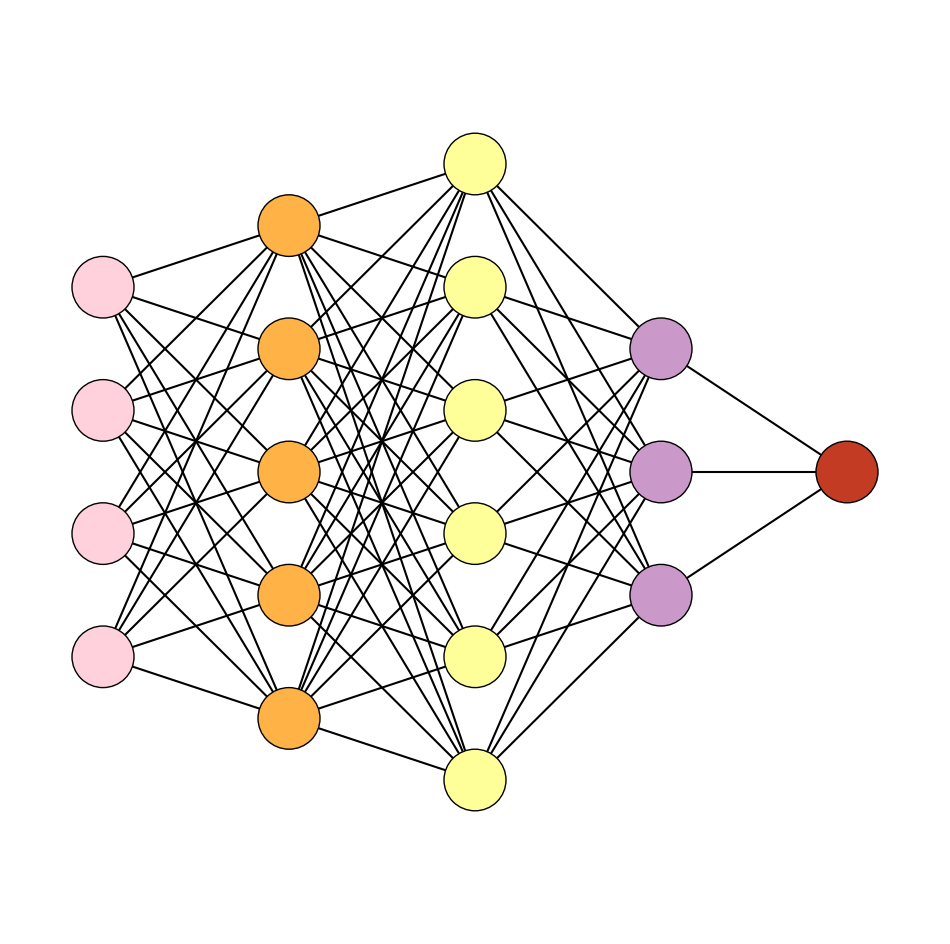

In [ ]:
draw_neural_net(layers)
plt.show()